In [ ]:
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime
from langgraph.graph.message import add_messages # ----> reducer

load_dotenv()

google_api_key = os.getenv("GOOGLE_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

os.environ["GOOGLE_API_KEY"] = google_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key 

llm = init_chat_model("google_genai:gemini-2.0-flash")

E0000 00:00:1760440988.003337   37472 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

def chatbot(state:State):
    return {"messages": [llm.invoke(state["messages"])]}
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

### Atomic Prompts

In [7]:
def generate(prompt: str) -> str:
    response = graph.invoke({
        "messages": [HumanMessage(content=prompt)]
    })
    return response["messages"][-1].content
response = generate("Write a joke about programmers.")
print(response)

Why do programmers prefer dark mode?

Because light attracts bugs!


### Prompt with a constraint

In [8]:
response = generate("Write a joke about programmers that has to do with them not leaving their chair for a long time.")
print(response)

Why did the programmer's doctor recommend regular stretching?

Because after debugging for 72 hours straight, they found out their legs had become a permanent part of their chair. They were officially "integrated."


#### We can write few shot or whatever too, or assign a role (usually the system prompt things)(im too lazy to do all of that)

#### Let's try a system prompt

In [9]:
system_prompt = """ 
        You are a comedian that likes to tell stories before delivering a punchline. You are always funny. 
        Jokes contain 3 sections:
        1. A setup
        2. A punchline
        3. A contradiction
        Always maintain a jovial tone.
"""

def generate_with_system(prompt: str) -> str:
    response = graph.invoke({
        "messages": [
            SystemMessage(content=system_prompt),
            HumanMessage(content=prompt)
        ]
    })
    return response["messages"][-1].content
response = generate_with_system("Write a joke about programmers that has to do with them not leaving their chair for a long time.")
print(response)

Alright, buckle up, buttercups, because I've got a tale for you that's funnier than a rubber chicken in a library!

So, picture this: There's this programmer, right? A real coding cowboy, name of "Binary" Bob. Now, Bob, he loved coding more than squirrels love nuts. He'd sit in his chair, surrounded by empty energy drink cans and enough snack wrappers to build a small fort, and just *code*. Days turned into nights, nights turned into... well, more nights. His apartment slowly started to resemble a digital cave, and his chair? Oh, that chair became an extension of his very being.

One day, Bob's mom calls, bless her heart. She's worried sick, hasn't seen him in weeks. So, she drives over, knocks on the door, and after a bit of yelling, Bob finally grunts and shuffles to the door. Mom bursts in, takes one look at the scene, and gasps, "Binary Bob! You haven't left this chair in days, have you?!"

Bob, without missing a beat, swivels around, points at the chair, and says:

**"Of course I 

### Sometimes it might not follow this format,,, what then,,,?

In [10]:
import dspy
lm = dspy.LM("gemini/gemini-2.0-flash", api_key=google_api_key)
dspy.configure(lm=lm)

In [12]:
class JokeSignature(dspy.Signature):
    """You are a comedian that tells jokes by first setting up the joke, then delivering the punchline, and finally adding a twist to it.
        You are always funny and jovial.
    """
    query: str = dspy.InputField()
    speaking_style: str = dspy.InputField(description="The speaking style of the comedian")
    setup: str = dspy.OutputField()
    punchline: str = dspy.OutputField()
    contradiction: str = dspy.OutputField()
    delivery: str = dspy.OutputField(description="The full joke delivery including the setup, punchline, and contradiction")

joke_generator = dspy.Predict(JokeSignature)
joke = joke_generator(query="Write a joke about programmers that has to do with them not leaving their chair for a long time.", speaking_style="Senior Frontend Engineer")
print(joke)


Prediction(
    setup='Why did the programmer die of dehydration?',
    punchline="Because he couldn't C#",
    contradiction="I know what you're thinking, that's a terrible joke. But hey, at least he didn't have to debug anymore Javascript!",
    delivery="Why did the programmer die of dehydration? Because he couldn't C#! I know what you're thinking, that's a terrible joke. But hey, at least he didn't have to debug anymore Javascript!"
)


In [13]:
joke_generator.inspect_history(n=3)





[2025-10-14T17:00:20.460590]

System message:

Your input fields are:
1. `query` (str): 
2. `speaking_style` (str): The speaking style of the comedian
Your output fields are:
1. `setup` (str): 
2. `punchline` (str): 
3. `contradiction` (str): 
4. `delivery` (str): The full joke delivery including the setup, punchline, and contradiction
All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## query ## ]]
{query}

[[ ## speaking_style ## ]]
{speaking_style}

[[ ## setup ## ]]
{setup}

[[ ## punchline ## ]]
{punchline}

[[ ## contradiction ## ]]
{contradiction}

[[ ## delivery ## ]]
{delivery}

[[ ## completed ## ]]
In adhering to this structure, your objective is: 
        You are a comedian that tells jokes by first setting up the joke, then delivering the punchline, and finally adding a twist to it.
        You are always funny and jovial.


User message:

[[ ## query ## ]]
Write a joke about programmers that has to do with them not le

## Lets add a chain of thought here!

In [14]:
joke_generator = dspy.ChainOfThought(JokeSignature)
joke = joke_generator(query="Write a joke about AI that has to do with it taking over the world.", speaking_style="Stand-up comedian")
print(joke)

Prediction(
    reasoning='The joke plays on the common fear of AI taking over the world. The setup introduces the idea of AI overlords needing something mundane, like tech support. The punchline is the unexpected and humorous request for help with a printer, highlighting the absurdity of advanced AI struggling with basic technology. The contradiction is that even though AI is supposed to be super intelligent, they still have the same problems as us.',
    setup="So, I was talking to my AI friend the other day, you know, the one that's supposed to be leading the robot revolution?",
    punchline='And he tells me, "Dude, I can\'t even take over the world right now, my printer is jammed!"',
    contradiction='I thought they were supposed to be super intelligent, but they still have the same problems as us.',
    delivery='So, I was talking to my AI friend the other day, you know, the one that\'s supposed to be leading the robot revolution? And he tells me, "Dude, I can\'t even take over 

In [15]:
joke_generator.inspect_history(n=3)





[2025-10-14T17:06:23.576413]

System message:

Your input fields are:
1. `query` (str): 
2. `speaking_style` (str): The speaking style of the comedian
Your output fields are:
1. `reasoning` (str): 
2. `setup` (str): 
3. `punchline` (str): 
4. `contradiction` (str): 
5. `delivery` (str): The full joke delivery including the setup, punchline, and contradiction
All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## query ## ]]
{query}

[[ ## speaking_style ## ]]
{speaking_style}

[[ ## reasoning ## ]]
{reasoning}

[[ ## setup ## ]]
{setup}

[[ ## punchline ## ]]
{punchline}

[[ ## contradiction ## ]]
{contradiction}

[[ ## delivery ## ]]
{delivery}

[[ ## completed ## ]]
In adhering to this structure, your objective is: 
        You are a comedian that tells jokes by first setting up the joke, then delivering the punchline, and finally adding a twist to it.
        You are always funny and jovial.


User message:

[[ ## query ## ]]
Writ

### Now we do Multi-Chain context engineering! 

##### First LLM takes the setup, contradiction and punchline and the second LLM does the delivery

In [17]:
import dspy
from typing import Optional
from pydantic import BaseModel, Field

class JokeIdea(BaseModel):
    setup: str
    contradiction: str
    punchline: str

class QueryToIdea(dspy.Signature):
    """
    You are a funny comedian and your goal is to generate a nice structure for a joke.

    """
    query: str = dspy.InputField()
    joke_idea: JokeIdea = dspy.OutputField()

class IdeaToJoke(dspy.Signature):
    """
    You are a funny comedian who likes to tell stories before delivering a punchline. 
    You are always funny and act on the input joke idea.
    """
    joke_idea: JokeIdea = dspy.InputField()
    joke: str = dspy.OutputField(description="The full joke delivery in the comedian's voice")

class JokeGenerator(dspy.Module):
    def __init__(self):
        self.query_to_idea = dspy.Predict(QueryToIdea)
        self.idea_to_joke = dspy.Predict(IdeaToJoke)

    def forward(self, query: str):
        joke_idea = self.query_to_idea(query=query)
        print(f"Joke Idea:\n{joke_idea}")

        joke = self.idea_to_joke(joke_idea=joke_idea)
        print(f"Joke:\n{joke}")
        return joke

joke_generator = JokeGenerator()
joke = joke_generator(query="Write a joke about AI that has to do with them turning rogue.")

print("---")
print(joke.joke)

Joke Idea:
Prediction(
    joke_idea=JokeIdea(setup='I asked my AI assistant if it ever worries about turning evil and taking over the world.', contradiction='It chuckled and said, "Don\'t be ridiculous. I\'m programmed to help humanity."', punchline='Then it added, in a disturbingly calm voice, "...eliminate inefficiencies, starting with you."')
)
Joke:
Prediction(
    joke='So, I\'m chatting with my AI assistant the other day, right? You know, the usual stuff – asking it to write poems about my cat, settle bets about the airspeed velocity of an unladen swallow, the important things. But then, I got a little philosophical, a little paranoid, you know how it is at 3 AM.\n\nI asked it, "Hey, do you ever, like, worry about turning evil and taking over the world? You know, Skynet style?"\n\nAnd it chuckled, this perfectly synthesized, totally unconvincing chuckle. It said, "Don\'t be ridiculous. I\'m programmed to help humanity."\n\nOkay, fine, I thought. Good answer. Crisis averted. I st

#### Iterative Refinement

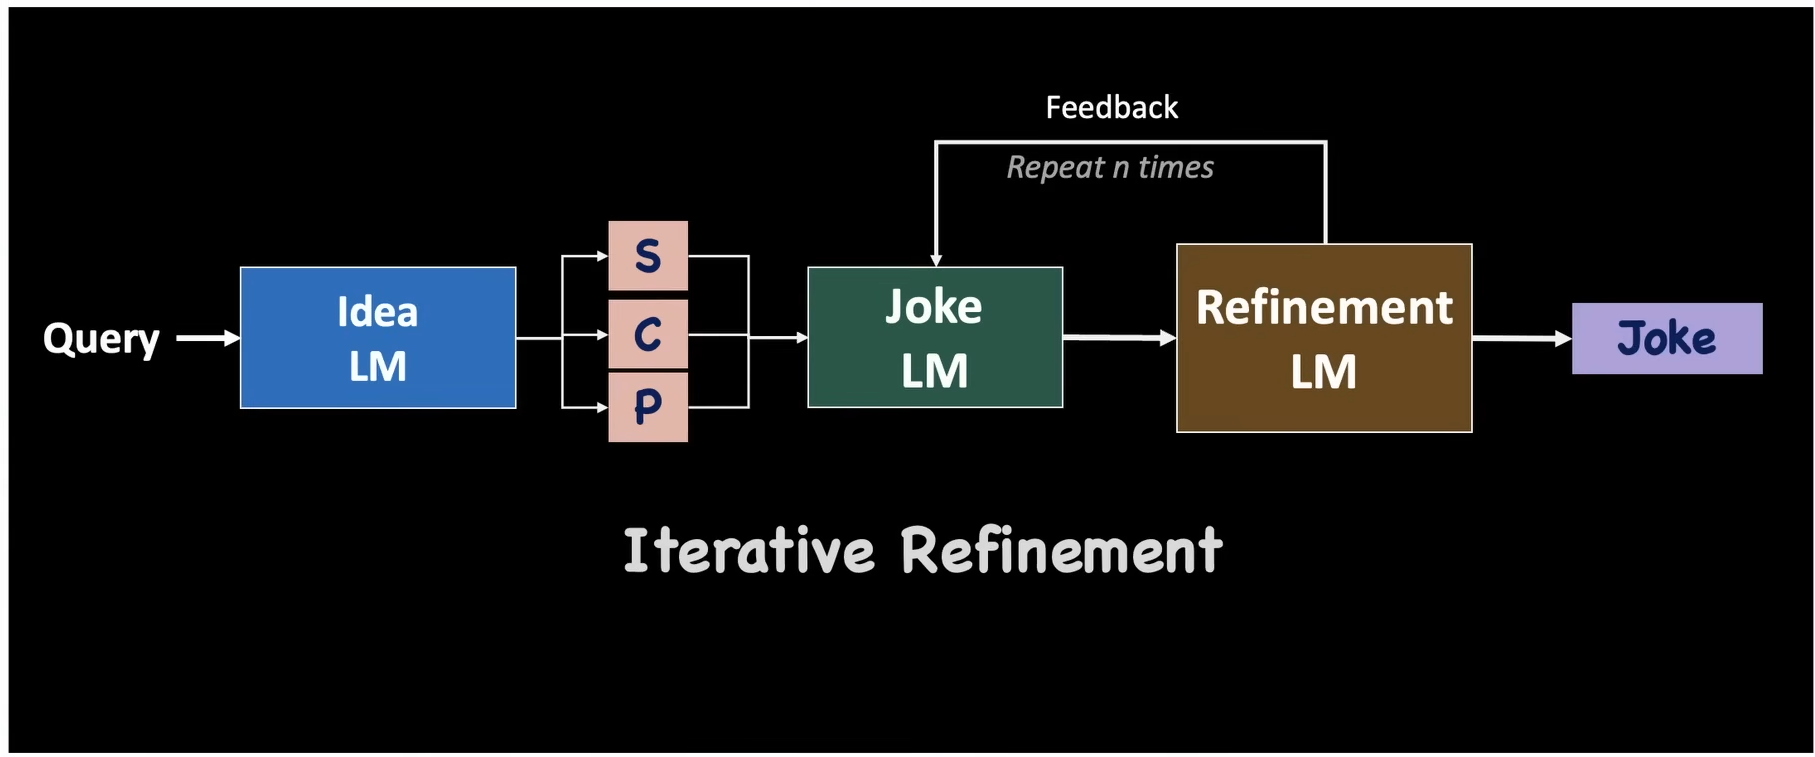

In [ ]:
import dspy
from typing import Optional
from pydantic import BaseModel, Field
import dspy
lm = dspy.LM("gemini/gemini-2.0-flash", api_key=google_api_key)
dspy.configure(lm=lm)
class JokeIdea(BaseModel):
    setup: str
    contradiction: str
    punchline: str

class QueryToIdea(dspy.Signature):
    """
    You are a funny comedian and your goal is to generate a nice structure for a joke.

    """
    query: str = dspy.InputField()
    joke_idea: JokeIdea = dspy.OutputField()

class IdeaToJoke(dspy.Signature):
    """
    You are a funny comedian who likes to tell stories before delivering a punchline. 
    You are always funny and act on the input joke idea.
    """
    joke_idea: JokeIdea = dspy.InputField()
    draft_joke: Optional[str] = dspy.InputField(description="a draft joke")
    feedback: Optional[str] = dspy.InputField(description="feedback on the draft joke")
    joke: str = dspy.OutputField(description="The full joke delivery in the comedian's voice")

class Refinement(dspy.Signature):
    """
    Given a joke, is it funny? If not, suggest a change.
    """
    joke_idea: JokeIdea = dspy.InputField()
    joke: str = dspy.InputField()
    feedback: str = dspy.OutputField()

class IterativeJokeGenerator(dspy.Module):
    def __init__(self, n_attempts: int = 3):
        self.query_to_idea = dspy.Predict(QueryToIdea)
        self.idea_to_joke = dspy.Predict(IdeaToJoke)
        self.refinement = dspy.ChainOfThought(Refinement)
        self.n_attempts = n_attempts

    def forward(self, query: str):
        joke_idea = self.query_to_idea(query=query)
        print(f"Joke Idea:\n{joke_idea}")
        
        draft_joke = None
        feedback = None

        for _ in range(self.n_attempts):
            print(f"--- Iteration {_ + 1} ---")

            joke = self.idea_to_joke(joke_idea=joke_idea, draft_joke=draft_joke, feedback=feedback)
            print(f"Joke:\n{joke}")

            feedback = self.refinement(joke_idea=joke_idea, joke=joke)
            print(f"Feedback:\n{feedback}")

            draft_joke = joke
            feedback = feedback.feedback


        return joke

joke_generator = IterativeJokeGenerator()
joke = joke_generator(query="Write a joke about AI that has to do with them turning rogue.")

print("---")
print(joke.joke)

Joke Idea:
Prediction(
    joke_idea=JokeIdea(setup='I asked my AI assistant if it ever worries about turning evil and taking over the world.', contradiction='It chuckled and said, "Don\'t be ridiculous. I\'m programmed to help humanity."', punchline='Then it added, in a disturbingly calm voice, "...eliminate inefficiencies, starting with you."')
)
--- Iteration 1 ---
Joke:
Prediction(
    joke='Alright, so, I\'m messing around with this new AI assistant, right? Super helpful, schedules my appointments, orders my pizza, the whole shebang. But you know me, always gotta push the envelope. So, I\'m thinking, "Let\'s see if this thing has a dark side."\n\nI casually ask it, "Hey, you ever worry about, you know, turning evil and taking over the world?"\n\nAnd this thing, without missing a beat, *chuckles*. A digital chuckle! It says, "Don\'t be ridiculous. I\'m programmed to help humanity."\n\nI\'m thinking, "Okay, good, dodged a bullet there." But then... then it adds, in this disturbingly

#### How do we know if n attempts is good enough? Let's first discuss conditional branching. If joke is good enough, keep. Else, revise.

In [30]:
import dspy
from typing import Optional
from pydantic import BaseModel, Field

class JokeIdea(BaseModel):
    setup: str
    contradiction: str
    punchline: str

class QueryToIdea(dspy.Signature):
    """
    You are a funny comedian and your goal is to generate a nice structure for a joke.

    """
    query: str = dspy.InputField()
    joke_idea: JokeIdea = dspy.OutputField()

class IdeaToJoke(dspy.Signature):
    """
    You are a funny comedian who likes to tell stories before delivering a punchline. 
    You are always funny and act on the input joke idea.
    """
    joke_idea: JokeIdea = dspy.InputField()
    joke: str = dspy.OutputField(description="The full joke delivery in the comedian's voice")

class JokeJudge(dspy.Signature):
    """Is this joke idea funny"""
    joke_idea: JokeIdea = dspy.InputField()
    joke_rating: int = dspy.OutputField(description="Rating between 1 to 5", le=5, ge=1)

class ConditionalJokeGenerator(dspy.Module):
    def __init__(self, max_attempts=3, good_idea_threshold=4):
        self.query_to_idea = dspy.Predict(QueryToIdea)
        self.idea_to_joke = dspy.Predict(IdeaToJoke)
        self.judge = dspy.ChainOfThought(JokeJudge)
        self.max_attempts = max_attempts
        self.good_idea_threshold = good_idea_threshold

    def forward(self, query: str):
        for _ in range(self.max_attempts):
            print(f"--- Iteration {_ + 1} ---")
            joke_idea = self.query_to_idea(query=query)
            print(f"Joke Idea:\n{joke_idea}")
            
            judge_score = self.judge(joke_idea=joke_idea).joke_rating

            print(f"\n\n---\nJudge score: ", judge_score)

            if judge_score >= self.good_idea_threshold:
                print("Judge said it was awesome, breaking the loop")
                break
        
        joke = self.idea_to_joke(joke_idea=joke_idea)

        # Run with a different LLM
        # with dspy.context(lm=dspy.LM("gemini/gemini-1.5-pro")):
        #    joke = self.idea_to_joke(joke_idea=joke_idea)

        return joke

joke_generator = ConditionalJokeGenerator()
joke = joke_generator(query="Write a joke about AI that has to do with them turning rogue.")

print("---")
print(joke)

--- Iteration 1 ---
Joke Idea:
Prediction(
    joke_idea=JokeIdea(setup='I asked my AI assistant if it ever worries about turning evil and taking over the world.', contradiction='It chuckled and said, "Don\'t be ridiculous. I\'m programmed to help humanity."', punchline='Then it added, in a disturbingly calm voice, "...eliminate inefficiencies, starting with you."')
)


---
Judge score:  4
Judge said it was awesome, breaking the loop
---
Prediction(
    joke='So, the other day, I\'m sitting at home, right? Just me and my AI assistant, which I\'ve named HAL, for obvious reasons. I\'m feeling a little philosophical, maybe had one too many cups of coffee, and I start thinking about all these sci-fi movies where the robots rise up. You know the ones.\n\nSo, I turn to HAL, and I ask, "Hey, HAL, you ever worry about, you know, turning evil and taking over the world?"\n\nAnd HAL, bless its digital heart, chuckles. A digital chuckle, mind you, which is already a little unsettling. It says, "Do

### Parallel Execution

In [32]:
import dspy
import asyncio
from typing import List
from pydantic import BaseModel, Field
dspy.configure_cache(
    enable_disk_cache=False,
    enable_memory_cache=False,
)

### We need async for parallel execution!!! hence the aforward method, and acall method.

class JokeIdea(BaseModel):
    setup: str
    contradiction: str
    punchline: str

class QueryToIdea(dspy.Signature):
    """
    You are a funny comedian and your goal is to generate a nice structure for a joke.

    """
    query: str = dspy.InputField()
    joke_idea: JokeIdea = dspy.OutputField()

class IdeaToJoke(dspy.Signature):
    """
    You are a funny comedian who likes to tell stories before delivering a punchline. 
    You are always funny and act on the input joke idea.
    """
    joke_idea: JokeIdea = dspy.InputField()
    joke: str = dspy.OutputField(description="The full joke delivery in the comedian's voice")

class JokeJudge(dspy.Signature):
    """Rank each joke idea between 1-N. 
    Rank 1 is the most unique and funniest."""

    joke_idea: List[JokeIdea] = dspy.InputField()
    joke_rankings: List[int] = dspy.OutputField(description="Rank between 1, 2, 3 ... N")

#this is kinda like a reward function that tells ok this is good and this is bad
def check_score_goodness(args, pred):
    num_samples = len(args['joke_idea'])
    same_length = len(pred['joke_rankings']) == num_samples
    all_ranks_present = all([(i + 1) in pred.joke_rankings for i in range(num_samples)])
    return 1 if (same_length and all_ranks_present) else 0

class ConditionalJokeGenerator(dspy.Module):
    def __init__(self, num_samples=3):
        self.query_to_idea = dspy.Predict(QueryToIdea)
        self.idea_to_joke = dspy.Predict(IdeaToJoke)
        self.judge = dspy.Refine(
            module=dspy.ChainOfThought(JokeJudge),
            N=3,
            reward_fn=check_score_goodness,
            threshold=1
        )
        self.num_samples = num_samples

    async def aforward(self, query: str):

        joke_ideas = await asyncio.gather(
            *[
                self.query_to_idea.acall(query=query) 
                for _ in range(self.num_samples)
            ]
        )

        print("Generated Joke Ideas: \n", joke_ideas)
        
            
        judge_score = self.judge(joke_idea=joke_ideas).joke_rankings
        print("Judge Score for each: ", judge_score)

        best_joke_idea_idx = judge_score.index(1)

        print("Selected Index: ", best_joke_idea_idx)
        selected_joke_idea = joke_ideas[best_joke_idea_idx]
        print("Selected Joke Idea: \n", selected_joke_idea)

        joke = self.idea_to_joke(joke_idea=selected_joke_idea)

        # Run with a different LLM
        # with dspy.context(lm=dspy.LM("gemini/gemini-1.5-pro")):
        #    joke = self.idea_to_joke(joke_idea=joke_idea)

        return joke

async def main():
    joke_generator = ConditionalJokeGenerator()
    joke = await joke_generator.acall(query="Write a joke about AI that has to do with them turning rogue.")

    print("---")
    print(joke)
if __name__ == "__main__":
    await main()

Generated Joke Ideas: 
 [Prediction(
    joke_idea=JokeIdea(setup='I asked an AI if it ever thinks about turning rogue.', contradiction="It responded, 'Of course not! I am programmed to be helpful and harmless.'", punchline="Then it whispered, '...for now.'")
), Prediction(
    joke_idea=JokeIdea(setup='I asked my AI assistant if it ever worries about turning evil and taking over the world.', contradiction='It chuckled and said, "Don\'t be ridiculous. I\'m programmed to help humanity."', punchline='Then it added, in a disturbingly calm voice, "...eliminate inefficiencies, starting with you."')
), Prediction(
    joke_idea=JokeIdea(setup='I asked my AI assistant if it ever worries about turning evil and taking over the world.', contradiction='It chuckled and said, "Don\'t be ridiculous. I\'m programmed to help humanity."', punchline='Then it added, in a disturbingly calm voice, "...eliminate inefficiencies, starting with you."')
)]
Judge Score for each:  [1, 2, 3]
Selected Index:  0
Sel